<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/qda_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team members:

*   Rudolf Braun
*   Jannik Schacht
*   Kieran Didi

# 1. Data preparation

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

In [2]:
digits = load_digits() 
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Data filtering (indeed we have 361 instances with a dimension of 8x8=64 each)



In [4]:
X_all = data
y_all = target

X_filter = X_all[np.logical_or(1 == y_all, 7 == y_all)]
y_filter = y_all[np.logical_or(1 == y_all, 7 == y_all)]
X_filter.shape

(361, 64)

Split into training and test set (here just for demonstration, later done on the data with reduced dimensions)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_filter, y_filter,
   test_size = 0.4, random_state = 0)

Visualize a few numbers to make sure we have the correct images

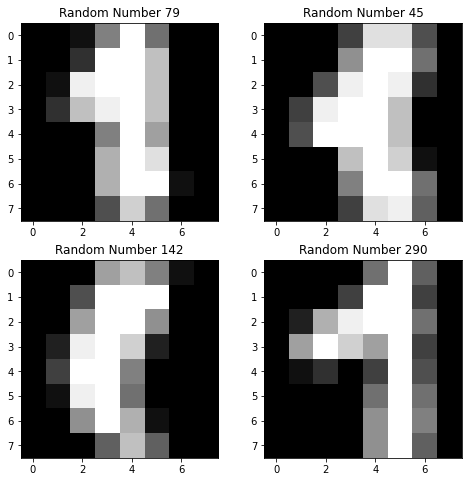

In [6]:
fig, axs = plt.subplots(2, 2)
sel = np.random.randint(low=0, high=361, size=4)
for r, x, y in zip(sel, [0, 0, 1, 1], [0, 1, 0, 1]):
    img = X_filter[r, :].reshape((8,8))
    assert 2 == len(img.shape)
    axs[x, y].imshow(img, interpolation="nearest", cmap="gray")
    axs[x, y].set_title(f"Random Number {r}")
fig.set_size_inches(8, 8)

# 1.1 Dimension Reduction

Look at the values of pixels in different instances

In [7]:
#separate 7's and 1's
X_one = X_filter[1 == y_filter]
X_seven = X_filter[7 == y_filter]

#calculate the means of each pixel in the respective classes and take the difference 
mean_diff = X_one.mean(axis=0)-X_seven.mean(axis=0)

#look for the top 5 pixels most bright for 1's and 7's respectively
idx_one = (mean_diff).argsort()[:5]
idx_seven = (-mean_diff).argsort()[:5]

print(idx_one)
print(mean_diff[idx_one])
print(idx_seven)
print(mean_diff[idx_seven])

[10 29 37  5 30]
[-6.46479219 -6.08244828 -5.82485113 -4.95100988 -4.69332065]
[19 60 61 27 52]
[12.5387071  10.82076862  8.56574989  8.03431764  7.7054147 ]


The first two pixels in each case seem to make the biggest difference, so we choose a linear combination of those pixels ($p_{xx}$) as our features:      
$f_1 = p_{10} + p_{29}$ <br>
$f_2 = p_{19} + p_{60}$

In [8]:
def reduce_dim(x):
    #define indices to be selected
    idx_1 = np.array([19, 60])
    idx_7 = np.array([10, 29])

    #select entries via indices and calculate new features from them
    x_1 = np.sum(x.take(idx_1, axis=1), axis=1)
    x_7 = np.sum(x.take(idx_7, axis=1), axis=1)
    #reduced_x = x.take(idx, axis=1)
    #combine the two features into one array
    reduced_x = np.column_stack((x_1, x_7))
    return reduced_x


In [9]:
reduced_x = reduce_dim(X_filter)
reduced_x.shape

(361, 2)

# 1.2 Scatterplot

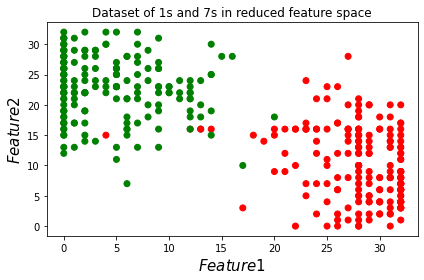

In [10]:
#plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
color= ['red' if y == 1 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color)

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

fig.tight_layout()
plt.show()

The two classes don't overlap too much, but are present as two separate clusters as visualised in the plot above. From this we can conclude that the reduced features are informative enough to continue.

# 2 Nearest Mean

# 2.1 Implement the nearest mean classifier

For this we use calculate the mean of the two classes, store them in an array and use the approach for distance function computation suggested in the sample solution last week.

In [11]:
def dist_vec(training, test):
  AB = np.dot(test, np.transpose(training)) # shape is (n_test, n_train)
  AA = np.sum(np.square(test), axis=1) # shape is (n_test,)
  BB = np.sum(np.square(training), axis=1) # shape is (n_train,)
  dist_matrix = np.sqrt(np.transpose(BB - 2 * AB) + AA) # shape is (n_train, n_test)
  return dist_matrix

First, split the dataset with reduced dimensions intro train and test set

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(reduced_x, y_filter,
   test_size = 0.4, random_state = 0)

In [13]:
X_test.shape

(145, 2)

In [14]:
def nearest_mean(training_features, training_labels, test_features):

  #calculate means for both classes
  train_1 = training_features[1 == training_labels]
  train_7 = training_features[7 == training_labels]
  mean_1 = np.mean(train_1, axis=0)
  mean_7 = np.mean(train_7, axis=0)
  means = np.vstack((mean_1, mean_7))
  #print(means)

  #compute distance matrix between test data and means of training data
  dist = dist_vec(means, test_features)
  #print(dist.shape)

  #predicts labels for test data based on closer mean
  indices = np.argsort(dist, axis=0)
  #print(indices.shape)
  predicted_labels = indices[0]
  predicted_labels[predicted_labels==1] = 7
  predicted_labels[predicted_labels==0] = 1
  #print(indices)
  #print(dist)
  return predicted_labels, means

  #
    #return predicted_labels

In [15]:
predicted_labels, means = nearest_mean(X_train, y_train, X_test)
result = y_test - predicted_labels
print(result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


As can be seen in the result array above, there was only one misclassification in the test set (a 7 that the algorithm classified as 1, therefore the value of 6 in the array)

# 2.2 Visualize the decision region

To

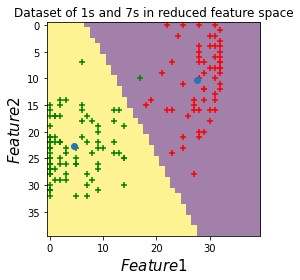

[[ 1.  2.  3. ... 38. 39. 40.]]
[[ 1.  1.  1. ... 40. 40. 40.]]
[[7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 ...
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]
 [7 7 7 ... 1 1 1]]


In [16]:
#create dataset for pixel image (40x40 instead of 200x200 since it caused a big distortion in the graph in that case)
f1 = np.linspace(1, 40, num=40)
f2 = np.linspace(1, 40, num=40)
xx, yy = np.meshgrid(f1,f2)
xx = xx.reshape(1,1600)
yy = yy.reshape(1,1600)
X_plot = np.dstack((xx,yy))
y_plot, means_plot = nearest_mean(X_train, y_train, X_plot)#?
y_plot = y_plot[:,0]
y_plot = y_plot.reshape(40,40)
#y_plot = y_plot.reshape(25,25)

#plot the pixel image dataset
fig, ax = plt.subplots()
color= ['red' if y == 1 else 'green' for y in y_test]
#color2= ['red' if y == 1 else 'green' for y in y_plot]#?



ax.imshow(y_plot, alpha = 0.5)#?
#ax.pcolor(x, y, z, cmap='RdBu')?
#ax.plot(xx, yy, ls="None", marker=".")
ax.scatter(X_test[:,0], X_test[:,1], c=color, marker = "+")
ax.scatter(means[:,0], means[:,1], marker = "o")

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

fig.tight_layout()
plt.show()
f1.shape
print(xx)
print(yy)
print(y_plot)

The blue points in the plot represent the respective class means, the scattered plus signs represent the test data, colored according to the class.
As determined already by the inspection of the corresponding array in 2.1, we see one misclassification on the side of the boundary.

# 3 QDA

# 3.1 Implement QDA Training

In [17]:
def fit_qda(training_features, training_labels): # fit the training data to a qda model
    l = len(training_labels)
    features_1 = [training_features[i] for i in range(l) if training_labels[i]==1] # features of all elements with label 1
    features_7 = [training_features[i] for i in range(l) if training_labels[i]==7] # features of all elements with label 7
    l1 = len(features_1)
    l7 = len(features_7)
    
    mu_1 = sum(features_1)/l1 # mu is a list of means of features
    mu_7 = sum(features_7)/l7
    mu = np.array([mu_1, mu_7])

    cov_1 = sum([np.outer(features_1[i]-mu_1, features_1[i]-mu_1) for i in range(l1)])/l1 # covaraint matrix of elements with label 1
    cov_7 = sum([np.outer(features_7[i]-mu_7, features_7[i]-mu_7) for i in range(l7)])/l7 # covaraint matrix of elements with label 7
    covmat = np.array([cov_1, cov_7])
    
    p = np.array([l1/l, l7/l]) # probabilities of the labels
    
    return mu, covmat, p
    # mu = (2,D) rows are the two class means
    # covmat = (2,D,D) two covariance matrices (D,D)
    # p = two priors

In [18]:
reduced_x_train = reduce_dim(X_train)
print(fit_qda(reduced_x_train, y_train)) # has issues after I copied it :/ I will try to fix it

IndexError: ignored

# 3.2 Implement QDA Prediction

In [19]:
def gaussian(mu, covmat, x): # gaussian, gives the probability of features x for given mu and covmat
    return (np.linalg.det(2*np.pi*covmat))**(-0.5)*np.exp(-0.5* np.linalg.inv(covmat).dot(mu-x).dot(mu-x))

def predict_qda(mu, covmat, p, test_features):
    prob = [[gaussian(mu[i], covmat[i], f) for i in range(2)] for f in test_features] # calculates the probabilities for the two classes
    predicted_labels = [1 if p[0]>p[1] else 7 for p in prob] # compares the probabilities and chooses the label with higher probability
    return predicted_labels

In [20]:
# fit the functions to the training data and test it on the training data and test data
reduced_x_train = reduce_dim(X_train)
reduced_x_test = reduce_dim(X_test)

mu, covmat, p = fit_qda(reduced_x_train, y_train)
predictions_train = predict_qda(mu, covmat, p, reduced_x_train)
predictions_test = predict_qda(mu, covmat, p, reduced_x_test)

error_train = sum([1 for i in range(len(y_train)) if predictions_train[i] != y_train[i]])/len(y_train)
error_test = sum([1 for i in range(len(y_test)) if predictions_test[i] != y_test[i]])/len(y_test)

print("error on the train data:", error_train*100 , "%")
print("error on the test data:", error_test*100 , "%")

IndexError: ignored

# 3.3 Visualization

In [ ]:
mu, covmat, p = fit_qda(reduced_x_train, y_train)
eig_val_1 , eig_vec_1 = np.linalg.eig(covmat[0])
eig_val_7 , eig_vec_7 = np.linalg.eig(covmat[1])

fig, ax = plt.subplots()

color= ['red' if y == 1 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color)

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

x = np.arange(0, 32, 1)
y = np.arange(0, 32, 1)
xg, yg = np.meshgrid(x, y)
z1 = [[gaussian(mu[0], covmat[0], [xx,yy]) for xx in x] for yy in y]
z7 = [[gaussian(mu[1], covmat[1], [xx,yy]) for xx in x] for yy in y]
plt.contour(z1)
plt.contour(z7)

vec_1 = np.array([eig_vec_1[i]*np.sqrt(eig_val_1[i]) for i in range(2)])
vec_7 = np.array([-eig_vec_7[i]*np.sqrt(eig_val_7[i]) for i in range(2)])
origin_1 = np.transpose(np.array([mu[0], mu[0]]), [1,0])
origin_7 = np.transpose(np.array([mu[1], mu[1]]), [1,0])
plt.quiver(*origin_1, vec_1[:, 0], vec_1[:, 1], color=['green','green'], scale =32)
plt.quiver(*origin_7, vec_7[:, 0], vec_7[:, 1], color=['red','red'], scale =32)

fig.tight_layout()
plt.show()

# 3.4 Performance evaluation